# HI wavelet transfrom starter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy
import scipy.signal as signal
import smplotlib
import astropy.io.fits as fits

import spectral_cube
from spectral_cube import SpectralCube
from tqdm import tqdm
import astropy.units as u
import astropy.constants as c
from astropy.table import Table
import matplotlib.ticker as ticker


In [3]:
# GIF packages
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize


In [4]:
# import pyWavelets package
import pycwt 
print(pycwt.__version__)

0.4.0b0


# Section 2: The Continuous Wavelet transform for HI

## Explination of the CWT

In [4]:
def constant_oscillation_morlet_wavelet(t, s=1, base_scale=1, w=2):
    """
    Generate a Morlet wavelet with a constant number of oscillations.
    :param t: Array of time points.
    :param s: Scale factor.
    :param base_scale: Base scale for the wavelet to maintain constant oscillations.
    :param w: Base frequency of the wavelet.
    :return: Morlet wavelet values at each time point.
    """
    C = np.pi**(-1/4) * np.sqrt(2 * s)
    # Adjust frequency to maintain constant oscillations
    adjusted_w = w * base_scale / s
    wavelet = C * np.exp(-t**2 / (2 * s**2)) * np.exp(1j * adjusted_w * t)
    return wavelet / np.max(np.abs(wavelet))


def shifted_wavelet(t, s=1, base_scale=1, w=2, shift=0):
    """
    Generate a shifted Morlet wavelet with a constant scale.
    :param t: Array of time points.
    :param s: Scale factor.
    :param base_scale: Base scale for the wavelet to maintain constant scale.
    :param w: Base frequency of the wavelet.
    :param shift: Shift along the x-axis.
    :return: Shifted Morlet wavelet values at each time point.
    """
    C = np.pi**(-1/4) * np.sqrt(2 * s)
    # Adjust frequency to maintain constant scale
    adjusted_w = w * base_scale / s
    wavelet = C * np.exp(-((t - shift)**2) / (2 * s**2)) * np.exp(1j * adjusted_w * (t - shift))
    return wavelet / np.max(np.abs(wavelet))




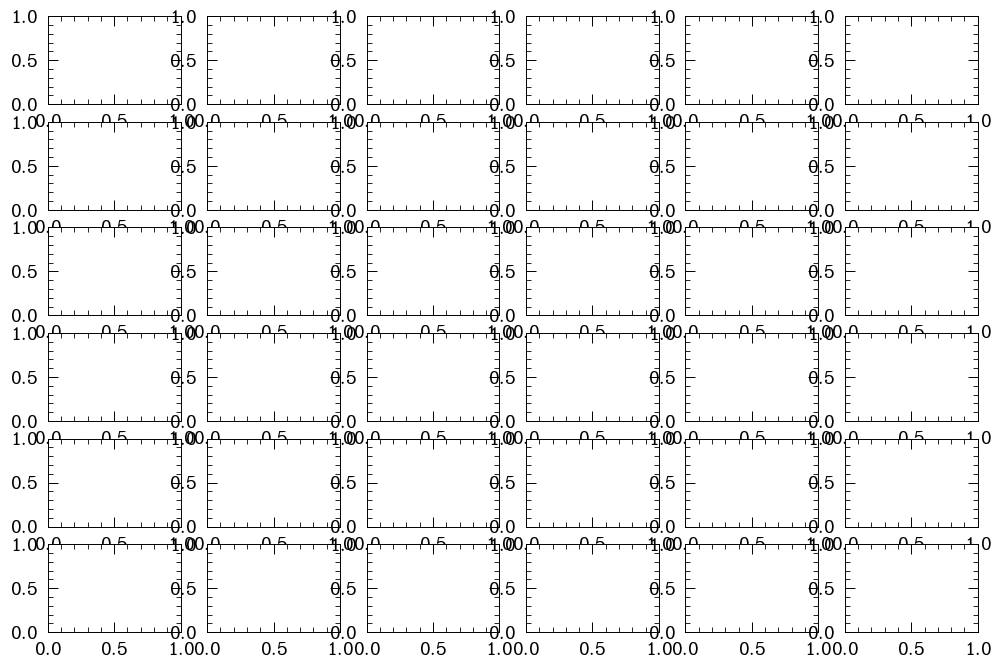

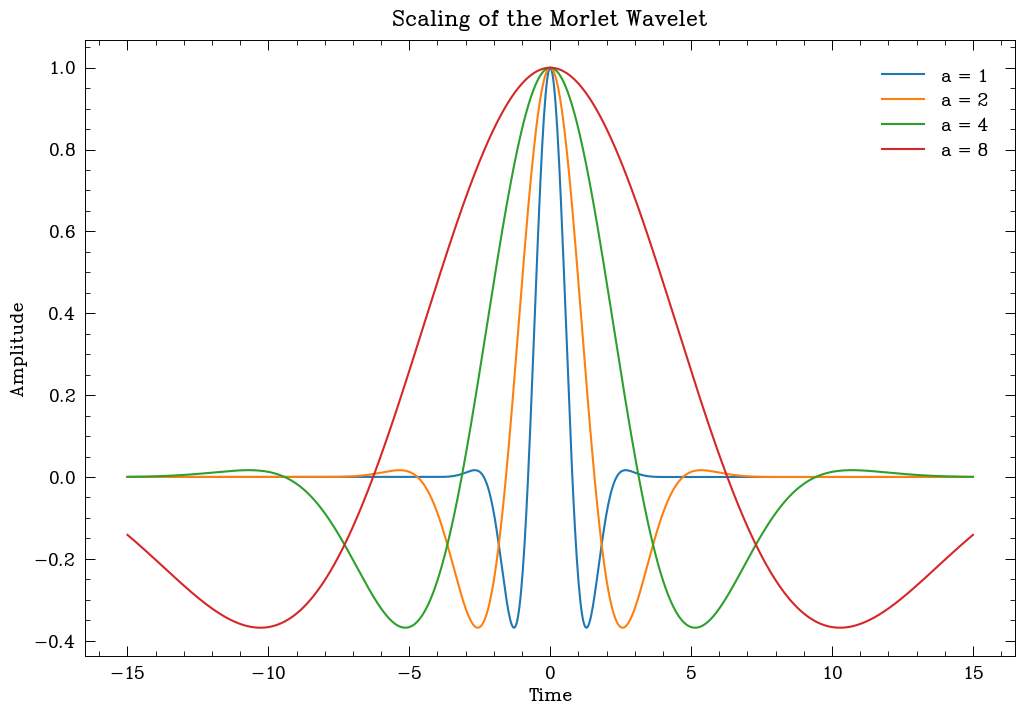

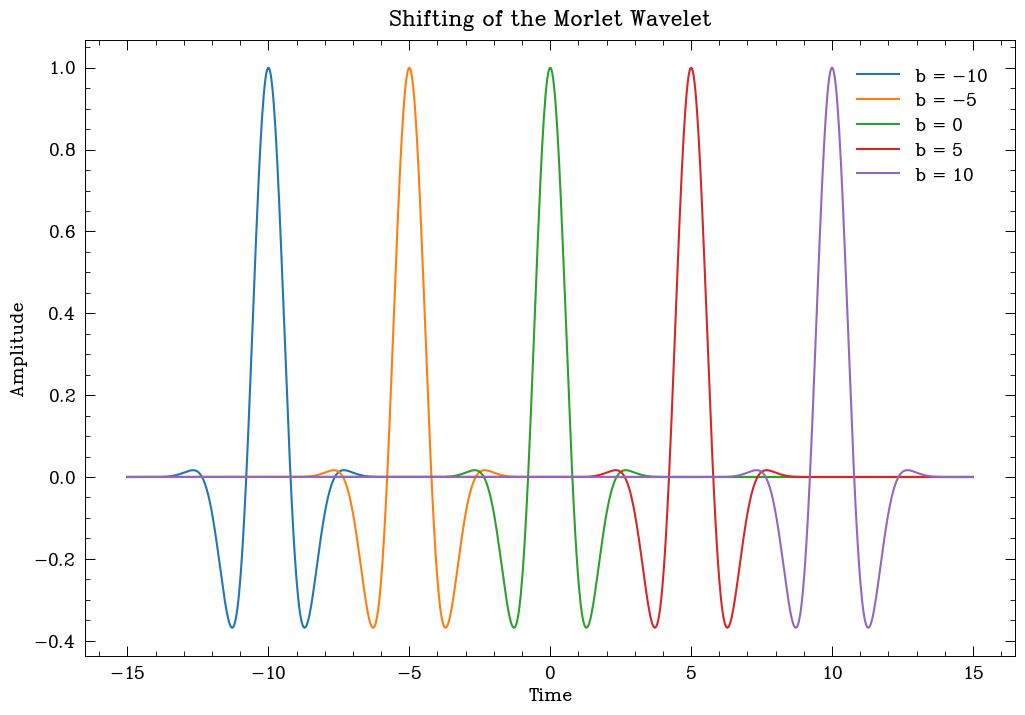

In [8]:
## Scale increse of the Morlet wavelet
# Time array
t = np.linspace(-15, 15, 1000)

# Different scales to demonstrate wavelet scaling
scales = [1, 2, 4, 8]

# Plotting
plt.figure(figsize=(12, 8))
for scale in scales:
    wavelet = constant_oscillation_morlet_wavelet(t, s=scale)
    plt.plot(t, np.real(wavelet), label=f'a = {scale}')

plt.title('Scaling of the Morlet Wavelet')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# plot the shifted wavelet all with the same scale
plt.figure(figsize=(12, 8))
shifts = [-10, -5, 0, 5, 10]
for shift in shifts:
    wavelet = shifted_wavelet(t, s=1, shift=shift)
    plt.plot(t, np.real(wavelet), label=f'b = {shift}')

plt.title('Shifting of the Morlet Wavelet')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


In [7]:

# Defining scales and alphas
scales = [1, 2, 4, 8, 10, 12]
alphas = np.linspace(0.5, 1, len(scales))
colors = plt.cm.Greys_r(np.linspace(0, 1, 4))


# Creating the adjusted grid of Morlet wavelets
fig, axs = plt.subplots(len(scales), len(alphas), figsize=(12, 8))

# Plotting adjusted wavelets in a grid
for i, scale in enumerate(scales):
    for j, alpha in enumerate(alphas):
        wavelet = adjusted_morlet_wavelet(t, s=scale)
        wavelet = constant_oscillation_morlet_wavelet(t, s=scale)
        axs[i, j].plot(t, np.real(wavelet), alpha=alpha, color='k')
        axs[i, j].spines['top'].set_visible(True)
        axs[i, j].spines['right'].set_visible(True)
        axs[i, j].spines['bottom'].set_visible(True)
        axs[i, j].spines['left'].set_visible(True)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])


plt.show()


NameError: name 'adjusted_morlet_wavelet' is not defined

## Applicaton to HI data Gaussians

In [ ]:
# generate a gaussian signal
N = 5000
t = np.linspace(-70, 70, N) # time vector
dt = np.diff(t)[0]
t0 = 0
x = np.exp(-t**2/(2*(2)**2)) 




# Wavelet transform with Morlet wavelet
p = np.polyfit(t - t0, x, 1) # this is to remove the trend from the signal to avoid the CWT to be dominated by the trend
dat_notrend = x - np.polyval(p, t - t0)  # detrended signal to avoid the CWT to be dominated by the trend
std = dat_notrend.std()  # Standard deviation
var = std ** 2  # Variance
data_norm = dat_notrend / std  # Normalized dataset

omega = 2*np.pi* (np.sqrt(1/(2*np.log(2))))
mother = pycwt.Morlet(6)
# mother = pycwt.DOG(4)
# mother = pycwt.MexicanHat()

s0 = 2 * dt  # Smallest scale. Determined by the Nyquist frequency of the signal. 
dj = 1/12   # The spacing between discrete scales. The smaller this is the better the wavelet will resolve the data. However the more scales used the more expensive it is to run.
J = np.log2(N*dt/s0)/dj # the largest scale
# alpha, _, _ = pycwt.ar1(x)

wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(data_norm, dt, dj, s0, J, mother)


fft_power = np.abs(fft) ** 2
fft_power_norm = fft_power / fft_power[0]


power = np.abs(wave)** 2 # Wavelet power spectrum
global_ws = (np.sum(power, axis=1) / N) 
period = 1 / freqs


# phase = np.arctan2(np.imag(wave), np.real(wave))

# print shapes of
print('x:', x.shape)
print('t:', t.shape)
print('wave:', wave.shape)
print('scales:', scales.shape)
print('freqs:', freqs.shape)
print('power:', power.shape)
print('global_ws:', global_ws.shape)
print('fft_power:', fft_power.shape)
print('fft_power_norm:', fft_power_norm.shape)
print('fftfreqs:', fftfreqs.shape)
print('period:', period.shape)



# plot as a 1 by 2 subplots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(t, x)
plt.title('Original Signal')

# the Fourier transform power spectrum and the wavelet transform power spectrum
plt.subplot(1, 2, 2)
plt.loglog(fftfreqs, fft_power_norm, label='FFT', c='k')
plt.loglog(1/period, global_ws, label='Global Wavelet Spectrum', c='b')
plt.title('Power Spectrum')
# plt.legend()
plt.xlim(0,10**3)
plt.axhline(0, color='black', lw=1, ls='--')
plt.show()



plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(wave), extent=[-1, 1, 0, 10], cmap='jet', aspect='auto',)
plt.gca().invert_yaxis()
plt.colorbar()

plt.subplot(1, 2, 2) # plot the phase 
plt.imshow(np.angle(wave), extent=[-1, 1, 0, 10], cmap='jet', aspect='auto',)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()





In [147]:
# Wavelet transform with Morlet wavelet fucntion 

def generate_wavelet_transform(x, t, mother='morlet'):
    """
    Generate a Gaussian signal and perform a Continuous Wavelet Transform (CWT)
    using a Morlet wavelet. The function computes the wavelet power spectrum,
    the Fourier power spectrum, and various other related quantities.

    Args:
        x (ndarray): Input signal.
        t (ndarray): Time vector.

    Returns:
        t (ndarray): Time vector.
        x (ndarray): Original Gaussian signal.
        wave (ndarray): Wavelet transform of the signal.
        scales (ndarray): Scales used in the wavelet transform.
        freqs (ndarray): Frequencies corresponding to the wavelet scales.
        power (ndarray): Wavelet power spectrum of the signal.
        fft_power (ndarray): Fourier power spectrum of the signal.
        fft_power_norm (ndarray): Normalized Fourier power spectrum.
        fftfreqs (ndarray): Frequencies corresponding to the FFT.
        period (ndarray): Periods corresponding to the wavelet frequencies.
    """

    
    dt = np.diff(t)[0]
    dt = np.abs(dt)
    N = len(t)  # number of samples


    # Remove the trend from the signal to avoid the CWT to be dominated by the trend
    p = np.polyfit(t, x, 1)  # remove the trend
    dat_notrend = x - np.polyval(p, t)  # detrended signal
    std = dat_notrend.std()  # standard deviation
    data_norm = dat_notrend / std  # normalized dataset

    # omega = 2 * np.pi * (np.sqrt(1 / (2 * np.log(2))))
    if mother == 'morlet':
        mother = pycwt.Morlet(6)
    elif mother == 'dog':
        mother = pycwt.DOG(4)
    elif mother == 'mexicanhat':
        mother = pycwt.MexicanHat()
    else:
        raise ValueError('Mother wavelet not recognized.')
    

    s0 = 2 * dt  # starting scale
    dj = 1 / 12   # twelve sub-octaves per octaves
    J = np.log2(N*dt/s0)/dj

    wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(data_norm, dt, dj, s0, J, mother)


    fft_power = np.abs(fft)# ** 2
    # find the index where k_v = 0 and normalize the power spectrum
    # idx = np.argwhere(fftfreqs == 0)
    fft_power_norm = fft_power / fft_power[0]

    power = np.abs(wave)#** 2 # Wavelet power spectrum
    global_ws = np.sum(power, axis=1) / N # Global wavelet spectrum
    period = 1 / freqs



    return wave, scales, freqs, power, global_ws, fft_power, fft_power_norm, fftfreqs, period, coi, fft 


In [5]:
def generate_gaussian(v, amplitude, mean, std_dev):

    return amplitude * np.exp(-((v - mean) ** 2) / (2 * std_dev ** 2))

def create_system(num_components, v, noise=False):
    """
    Creates a system with a specified number of Gaussian components.
    :param num_components: Number of Gaussian components in the system
    :param v: Velocity vector
    :return: Total signal from all components
    """
    total_signal = np.zeros_like(v)

    for i in range(num_components):
        # Define parameters for each component
        amplitude = np.random.uniform(0.5, 15)
        mean = np.random.uniform(-50, 50)
        std_dev = np.random.uniform(0.1, 4)

        # Add the Gaussian component to the total signal
        total_signal += generate_gaussian(v, amplitude, mean, std_dev)

        # Add minimal noise to the signal
        if noise:
            total_signal += np.random.normal(0, 0.1, len(v))
        

    return total_signal

In [ ]:

v = np.linspace(-70, 70, 10000) # Velocity vector
t = v

plt.figure(figsize=(20, 6))  # Adjusted figure size for two subplots

# Subplot 1: Systems with Different Numbers of Gaussian Components

for i in range(6, 10):
    total_signal = create_system(i, v)
    plt.plot(v, total_signal, label=f'{i} Component(s)')

    # apply the wavelet transform to 
    wave, scales, freqs, power, global_ws, fft_power, fft_power_norm, fftfreqs, period, coi, fft = generate_wavelet_transform(total_signal, t)

    plt.figure(figsize=(12, 6))

    # Plot CWT power spectrum
    plt.subplot(1, 2, 1)
    plt.loglog(fftfreqs, fft_power/fft_power[0], label='FFT', c='k')
    plt.loglog(1/period, global_ws/fft_power[0], label='Global Wavelet Spectrum', c='b')
    plt.axvline(0.12, color='blue', lw=1, ls='--', label='k = 0.12')
    plt.title(f'1D Power Spectrum - {i} Component(s)')
    plt.xlabel(r'$k_\nu$')
    plt.ylabel('Power')
    plt.legend()

    # Plot imshow of CWT
    plt.subplot(1, 2, 2)
    plt.imshow(power/fft_power[0], cmap='jet', aspect='auto', extent= [t.min(), t.max(), scales.min(), scales.max()])
    plt.colorbar()
    import matplotlib.ticker as ticker

    # levels = [0, 0.5, 1, 2, 4, 999]
    # # # *** or use 'contour'
    # CS = plt.contourf(t, period, power, len(levels))
    # im = plt.contourf(CS, levels=levels, colors=['white', 'bisque', 'orange', 'orangered', 'darkred'])

    # im = plt.pcolormesh(t, np.log2(period), np.log2(power), shading='auto', cmap='jet')
    # plt.colorbar(im)

    # # COI
    # plt.plot(t, np.log2(coi), )
    # plt.fill_between(t, np.log2(coi) * 0 + np.log2(period)[-1], np.log2(coi), facecolor="none", edgecolor="k", hatch='x')

    # # Scaling 
    # plt.yscale('log', base=2, subs=None)
    # plt.ylim([np.min(period), np.max(period)])

    ax = plt.gca().yaxis
    ax.set_major_formatter(ticker.ScalarFormatter())
    plt.ticklabel_format(axis='y', style='plain')


    plt.title(f'Scalogram - {i} Component(s)')
    plt.gca().invert_yaxis()
    plt.show()



In [ ]:
# COI
plt.fill_between(t, coi * 0 + period[-1], coi, facecolor="none", edgecolor="#00000040", hatch='x')
plt.plot(t, coi, )
# set y scale as log
plt.yscale('log', base=2)
plt.ylim([np.min(period), np.max(period)])
# make the ticks as plain
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')


plt.gca().invert_yaxis()
plt.show()

# The CWT at scale k = 0.12

In [ ]:
# Data
X = np.linspace(-70, 70, 10000) # Velocity vector
T_b = create_system(6, X) # Total signal

# Wavelet transform: Parameters
param = 6
k_v = 0.12
fourier_factor = 4 * np.pi / (param + np.sqrt(2 + param**2)) # this is the same as lambda in my notes 
scale = 1/(fourier_factor * k_v) 
dt = np.diff(T_b)[0]
n = len(T_b)


###### 



f = np.fft.fft(T_b) # FFT data

b = np.linspace(X.min(), X.max(), len(X))  # Translation values




v_sb = [X-b_i for b_i in b] / scale # Translation values
phi_v_sb = np.pi**(-0.25) * np.exp(param*1j*v_sb) * np.exp(-v_sb**2/2) # Daughter wavelets array
phi_v_sb_f = np.fft.fft(phi_v_sb) # FFT daughter wavelets

wave = np.fft.ifft(f * phi_v_sb_f) # Convolution of the data with the daughter wavelets 
print(wave)






 
# wavelet power spectrum
# power = np.abs(wave)
# plot X vs power and spectrum next to it
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(X, T_b)
plt.title('Original Signal')
plt.xlabel('X')
plt.ylabel('T_b')

plt.subplot(1, 2, 2)
plt.plot(X, power)
plt.title('Wavelet Power Spectrum')
plt.xlabel('X')
plt.ylabel('Power')
plt.show()


In [ ]:


# FFT of the signal
fft_signal = np.fft.fft(x)
fftfreqs = np.fft.fftfreq(len(x), dv)

# Define the FFT of the morelet wavelet at scale 0.12 
k_v = 0.12
omega_0 = 6
lambda_v = 4 * np.pi /(omega_0 + np.sqrt(2 + omega_0 ** 2))
scale = 1/(lambda_v * k_v)

n = len(x)

# construct wavenumber array used in transform [Eqn(5)]
kplus = np.arange(1, int(n / 2) + 1)
kplus = (kplus * 2 * np.pi / (n * dv))
kminus = np.arange(1, int((n - 1) / 2) + 1)
kminus = np.sort((-kminus * 2 * np.pi / (n * dv)))
k = np.concatenate(([0.], kplus, kminus))

k0 = omega_0
n = len(k)


expnt = -(scale * k - k0) ** 2 / 2. * kplus
norm = np.sqrt(scale * k[1]) * (np.pi ** (-0.25)) * np.sqrt(n)
daughter = norm * np.exp(expnt)
daughter = daughter * kplus  # Heaviside step function
# Scale-->Fourier [Sec.3h]
fourier_factor = (4 * np.pi) / (k0 + np.sqrt(2 + k0 ** 2))
coi = fourier_factor / np.sqrt(2)  # Cone-of-influence [Sec.3g]
dofmin = 2  # Degrees of freedom



# in FFT space a convolution is a multiplication, so multiply the FFT of the signal with the FFT of the wavelet




# Compute the inverse FFT to get the convolution of the signal and the wavelet at scale 0.12,

wave = np.fft.ifft(fft_signal * daughter)
power = np.abs(wave)
# there is no gloabl power spectum as there is only one scale nor is there a 2D power spec



wave: (1, 500)
scale: ()
coi: (500,)
fft_freqs: (500,)
fft_signal: (500,)
[0.00057467]
0.4834602297650431


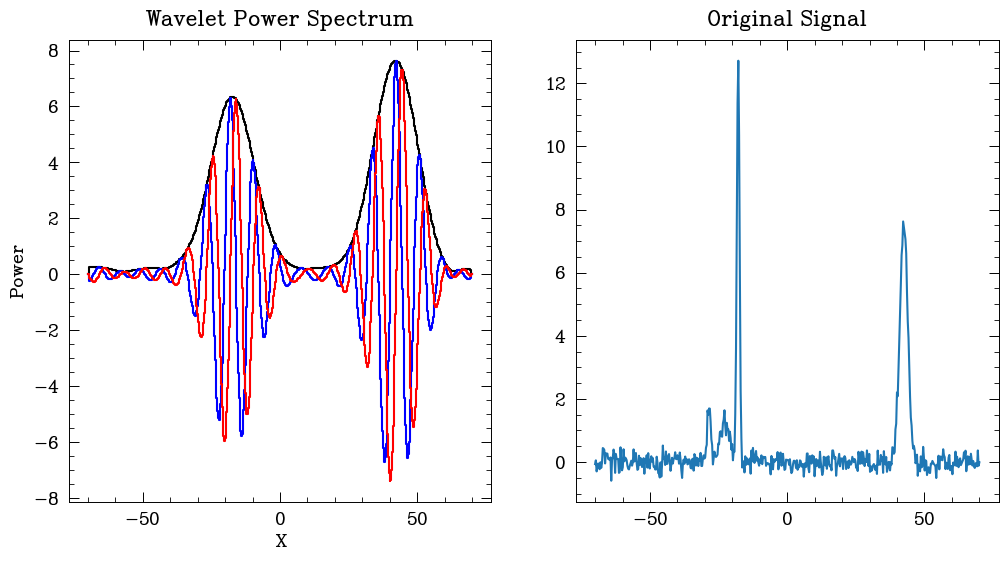

In [88]:
def wavelet(Y, dt, pad=True, dj=-1, s0=-1, J1=-1, mother='MORLET', param=6., freq=None, k_v = 0.12):

    n1 = len(Y)
    
    # Find and mask a mean noise, from the first 10 and last 10 points of the data
    # noise_first = np.mean(Y[:10])
    # noise_last = np.mean(Y[-10:])
    # if noise_first < noise_last:
    #     noise = noise_first
    # else:
    #     noise = noise_last

    # mask = Y < noise
    # Y[mask] = 0 
   

    x = Y 
    # Pad the data otherwise the wavelet transform will be dominated by the edges
    if pad == True:
            # power of 2 nearest to N
            base2 = np.fix(np.log(n1) / np.log(2) + 0.4999)
            nzeroes = (2 ** (base2 + 1) - n1).astype(np.int64)
            x = np.concatenate((x, np.zeros(nzeroes)))
    
    n = len(x)


    # construct wavenumber array used in transform (C. Torrence and G. P. Compo 1998, [Eqn(5)] )
    kplus = np.arange(1, int(n / 2) + 1)
    kplus = (kplus * 2 * np.pi / (n * dt))
    kminus = np.arange(1, int((n - 1) / 2) + 1)
    kminus = np.sort((-kminus * 2 * np.pi / (n * dt)))
    k = np.concatenate(([0.], kplus, kminus))


    # compute FFT of the (padded) time series
    f = np.fft.fft(x)  # (C. Torrence and G. P. Compo 1998, [Eqn(3)])
    fft_freqs = np.fft.fftfreq(len(x), dt) 



    param = 6. # This is omega_0. omega_0 = 2pif_0. This sets the frequency of the of the sine wave used in the Morlet wavelet
    fourier_factor = 4 * np.pi / (param + np.sqrt(2 + param**2)) 

    scale = 1/(fourier_factor * k_v) # Scale corresponding to k_v. The width of the Gaussian evnvolope of the Morlet wavelet
    period = 1. / k_v 



    # define the wavelet array
    wave = np.zeros((1, n), dtype=complex)

    ###  loop through all scales and compute transform
    # daughter, fourier_factor, coi = wave_bases(mother, k, scale, param)

    kplus = np.array(k > 0., dtype=float)
    k0 = np.copy(param)

    # Calcaulte (C. Torrence and G. P. Compo 1998, psi_0(s omega) from Table 1)
    expnt = -(scale * k - k0) ** 2 / 2. * kplus
    norm = np.sqrt(scale * k[1]) * (np.pi ** (-0.25)) * np.sqrt(n)
    daughter = norm * np.exp(expnt)
    daughter = daughter * kplus  # Heaviside step function

    # (C. Torrence and G. P. Compo 1998, [Sec.3h])
    fourier_factor = (4 * np.pi) / (k0 + np.sqrt(2 + k0 ** 2))

    # Cone of influence (C. Torrence and G. P. Compo 1998, [Sec.3g])
    coi = fourier_factor / np.sqrt(2)  
    coi = coi * dt * np.concatenate((
            np.insert(np.arange(int((n1 + 1) / 2) - 1), [0], [1E-5]),
            np.insert(np.flipud(np.arange(0, int(n1 / 2) - 1)), [-1], [1E-5])))


    ## Wavelet transform in Fourier space. (C. Torrence and G. P. Compo 1998, [Eqn(4)])

    wave[:, :] = np.fft.ifft(f * daughter)
    # remove padding before returning
    wave = wave[:, :n1]
    fft_freqs = fft_freqs[:n1]
    f = f[:n1]

    # Create a mask based on the COI
    mask = np.abs(wave) < np.tile(coi, [wave.shape[0], 1]) 
    wave[~mask] = 0 # set the values outside the COI to zero
    # wave[~mask] *= 0.5 # downweight the values

    return wave, period, scale, coi, f, fft_freqs


# def wave_bases(mother, k, scale, param):
#     n = len(k)
#     kplus = np.array(k > 0., dtype=float)

#     param = 6.

#     k0 = np.copy(param)
#     # calc psi_0(s omega) from Table 1
#     expnt = -(scale * k - k0) ** 2 / 2. * kplus
#     norm = np.sqrt(scale * k[1]) * (np.pi ** (-0.25)) * np.sqrt(n)
#     daughter = norm * np.exp(expnt)
#     daughter = daughter * kplus  # Heaviside step function

#     # Scale-->Fourier [Sec.3h]
#     fourier_factor = (4 * np.pi) / (k0 + np.sqrt(2 + k0 ** 2))
#     coi = fourier_factor / np.sqrt(2)  # Cone-of-influence [Sec.3g]


#     return daughter, fourier_factor, coi


#### wavelet transform

v = np.linspace(-70, 70, 500) 
x = create_system(4, v, noise=True)
dv = np.diff(v)[0]


wave, period, scale, coi, fft_signal, fft_freqs = wavelet(x, dv, dj=1/12, mother='MORLET')

N_chan = 10000
power =  np.abs(wave)
global_ws = np.sum(power, axis=1) /(np.abs(fft_signal)[0]) / N_chan


fft_power = np.abs(fft_signal)/ np.abs(fft_signal)[0]

print('wave:', wave.shape)
# print('period:', period.shape)
print('scale:', scale.shape)
print('coi:', coi.shape)
print('fft_freqs:', fft_freqs.shape)
print('fft_signal:', fft_signal.shape)

print(global_ws)
idx = np.argmin(np.abs(fft_freqs - 0.12))
print(fft_power[idx])

# plot the power in the fft with the powerin the wavelet transform and the 2d wavelet transform
plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.loglog(fft_freqs, fft_power, label='FFT', c='k')
# plt.scatter(np.abs(1/period), global_ws, label='Global Wavelet Spectrum', c='b', lw=14)
# plt.title('Power Spectrum')
# plt.axvline(0.12, color='blue', lw=1, ls='--', label='k = 0.12')

plt.subplot(1, 2, 1)
plt.step(v, power[0], label='Wavelet Power Spectrum', c='k')
plt.step(v, wave.real[0], label='Wavelet Transform', c='b')
plt.step(v, wave.imag[0], label='Wavelet Transform', c='r')
plt.title('Wavelet Power Spectrum')
plt.xlabel('X')
plt.ylabel('Power')



# plt.legend(loc = 'upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1)
# plt.ylim(10**-5, 10**2)

plt.subplot(1, 2, 2)
plt.plot(v, x)
plt.title('Original Signal')

plt.show()


    






# Case Study 1: 21-sponge 
- plot 1: HI data
- plot 2: Imshow of the CWT of the HI data
- plot 3: 1:1 of fCNM from CWT and the KOK and FFT and GauspyPlus

# Case Study 2: The Magellanic System

- plot 1: HI data
- plot 2: Cold gas map of the magellanic system
- plot 3: Link to move PPVk cube

# Case Study 3: Absorption 
- plot 1: HI data (The bighicat dataset.)
- plot 2: CWT imshow of the HI data
- plot 3: 1:1 of fCNM from CWT and ther measuremtns along with FFT

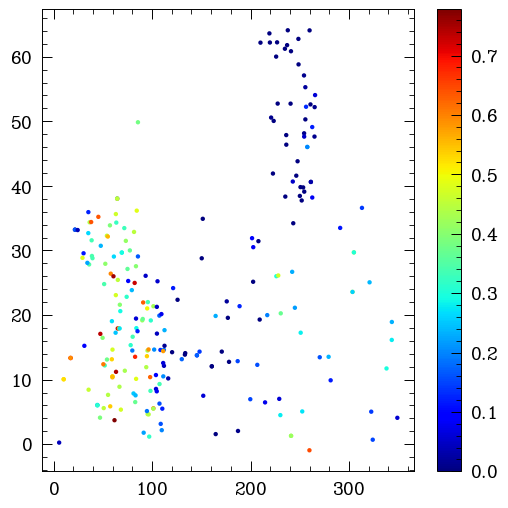

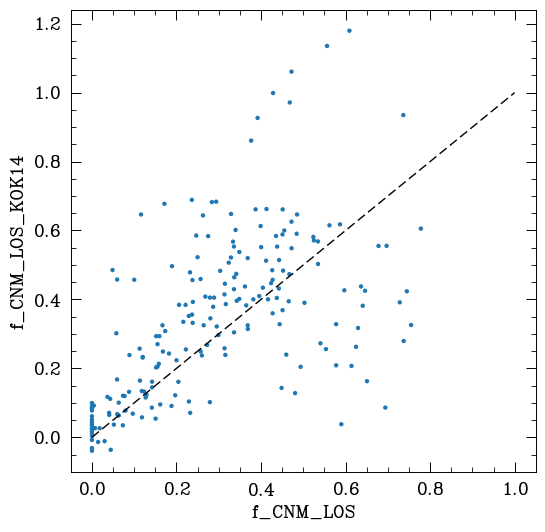

In [33]:
abs_data = 'HI_abs_data/all_unique_CNM_det_gaussian_components_new.csv'
abs_data = Table.read(abs_data, format='csv')
abs_LOS_data = 'HI_abs_data/all_unique_LOS_new.csv'
abs_LOS_data = Table.read(abs_LOS_data, format='csv')

plt.scatter(abs_LOS_data['ra'], abs_LOS_data['dec'], c=abs_LOS_data['f_CNM_LOS'], cmap='jet', s=10, edgecolors='none')
plt.colorbar()
plt.show()


# one to one plot 
plt.scatter(abs_LOS_data['f_CNM_LOS'], abs_LOS_data['f_CNM_LOS_KOK14'], s=10, edgecolors='none')
plt.xlabel('f_CNM_LOS')
plt.ylabel('f_CNM_LOS_KOK14')
# one to one line from 0 to 1
plt.plot([0, 1], [0, 1], c='k', lw=1, ls='--')
plt.show()



In [81]:
datafile = 'Data_abs/Mach/J14364.fits'
data, header = fits.getdata(datafile, header=True)

tau    = data['tau_hi']
vlsr   = data['v_lsr']
sigtau = data['sigma_tau_hi']
nspecs = 40
nchan  = len(vlsr)
tb_arr = np.zeros((nspecs, nchan))

for i in range(nspecs):
    tb_arr[i,:] = data[f'tb_ebhis_{i}']
    sigtb  = data['sigma_tb_ebhis']
    emt    = np.exp(-tau)
    sigemt = np.abs( np.exp(-tau)*sigtau )

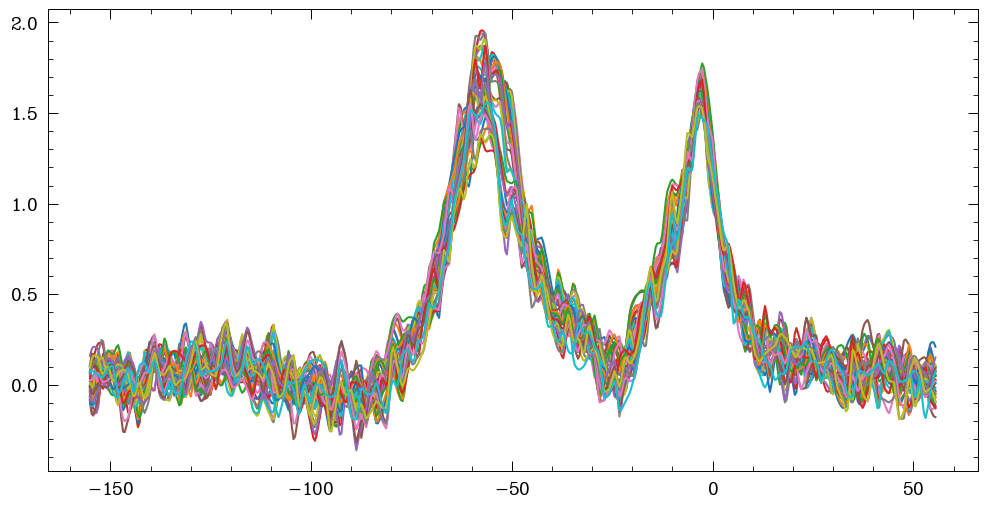

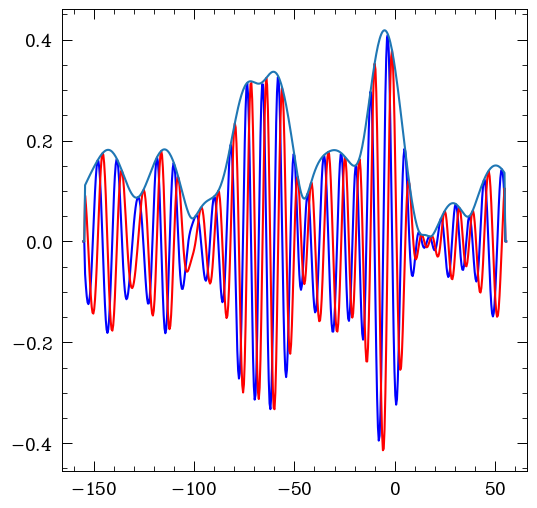

In [94]:
# plot the data
plt.figure(figsize=(12, 6))
# plot all the spectra
for i in range(nspecs):
    plt.plot(vlsr, tb_arr[i], label=f'Spectrum {i}')

plt.show()

dv = np.diff(vlsr)[0]

wave = np.zeros((nspecs, nchan), dtype=complex)

for i in range(nspecs):
    waves, period, scale, coi, fft_signal, fft_freqs = wavelet(tb_arr[1], dv, mother='MORLET', k_v=0.12)
    wave[i] = waves


plt.plot(vlsr, wave.real[0], label='Wavelet Transform', c='b')
plt.plot(vlsr, wave.imag[0], label='Wavelet Transform', c='r')
plt.plot(vlsr, np.abs(wave[0]), label='Abs')
plt.show()


# Case Study 4: Spider

Data shape: (711, 172, 171)
Velocity shape: (711,)
WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SFL'  'GLAT-SFL'  'VOPT-F2W'  
CRVAL : 134.978379356  0.0  400685.786735  
CRPIX : 86.0  -598.7133789  -89.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.05833333358  0.05833333358  -807.2265299229  
NAXIS : 0  0


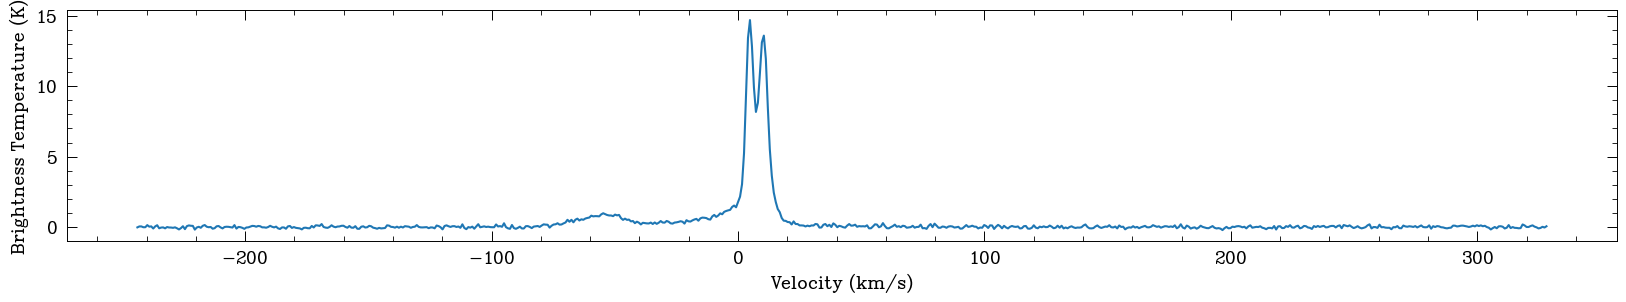

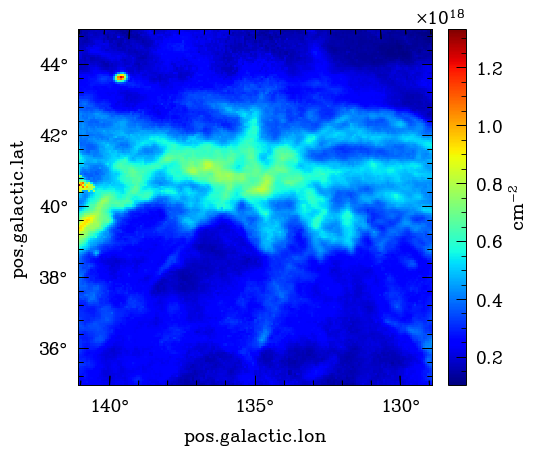

In [30]:
spider_data = fits.getdata('RSAA_SP/Data/GHIGLS_SPIDER_Tb.fits')
spider_data = spider_data[0,:,:]

column_density = np.sum(spider_data*1.823*10**18 / 1000, axis=0)   # m/s to km/s


spider_moments = SpectralCube.read('RSAA_SP/Data/GHIGLS_SPIDER_Tb.fits')
velocity_spider = spider_moments.spectral_axis.to(u.km/u.s).value  # velocity component
wcs_spider = spider_moments.wcs

print('Data shape:', spider_data.shape)
print('Velocity shape:', velocity_spider.shape)
print(wcs_spider)

# plot a spectum from the middle of the data
plt.figure(figsize=(20, 3))
plt.plot(velocity_spider, spider_data[:,80, 80])
plt.xlabel('Velocity (km/s)')
plt.ylabel('Brightness Temperature (K)')
plt.show()

# plot the HI column density image by summing along the velocity axis
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection = wcs_spider.celestial)
im = ax.imshow(column_density, cmap='jet', origin='lower', )
plt.colorbar(im, fraction=0.046, pad=0.04, label='cm$^{-2}$')
plt.show()


In [31]:
# Apply wavelet transform to the spider data

filtered_spider_cube = np.zeros(spider_data.shape)

total_power = np.zeros((103, len(velocity_spider))) # Power at every scale along the velocity axis
total_global_ws = np.zeros(103) # Global wavelet spectrum
total_fft = np.zeros(511) # Fourier power spectrum



spider_data[spider_data != spider_data] = 0  # Set the NaN values to zero

for i in tqdm(np.arange(spider_data.shape[1])):
    for j in np.arange(spider_data.shape[2]):

        x = spider_data[:, i, j] # spectrum at each pixel
        wave, scales, freqs, power, global_ws, fft_power, fft_power_norm, fftfreqs, period, coi, fft = generate_wavelet_transform(x, velocity_spider)

        N = len(velocity_spider)  # number of samples
        total_power += power # Power at every scale along the velocity axis (2D power spectrum at each pixel) 
        total_global_ws += global_ws # Global (1D) wavelet spectrum at each pixel
        total_fft += fft_power # Fourier power spectrum at each pixel


        # identify the cold gas component
        target_x = 0.12
        idx = np.argmin(np.abs(np.abs(1/period) - target_x))
    
        # Clip power spectrum baed on the COI - TODO!!
        # clip the power spectrum based on the COI


        f_cnm = np.sum(power[idx]) / np.sum(power, axis=0) / power.shape[1] # fraction of the power in the cold gas component


        filtered_spider_cube[:, i, j] = f_cnm



print('Filtered cube shape:', filtered_spider_cube.shape)
print('Wave shape:', wave.shape)
print('Power shape:', power.shape)
print('global_ws shape:', global_ws.shape)
print('fftfreqs shape:', fftfreqs.shape)
print('period shape:', period.shape)
print('f_cnm shape:', f_cnm.shape)
print('idx:', idx)

  0%|          | 0/172 [00:00<?, ?it/s]

100%|██████████| 172/172 [01:53<00:00,  1.52it/s]

Filtered cube shape: (711, 172, 171)
Wave shape: (103, 711)
Power shape: (103, 711)
global_ws shape: (103,)
fftfreqs shape: (511,)
period shape: (103,)
f_cnm shape: (711,)
idx: 28


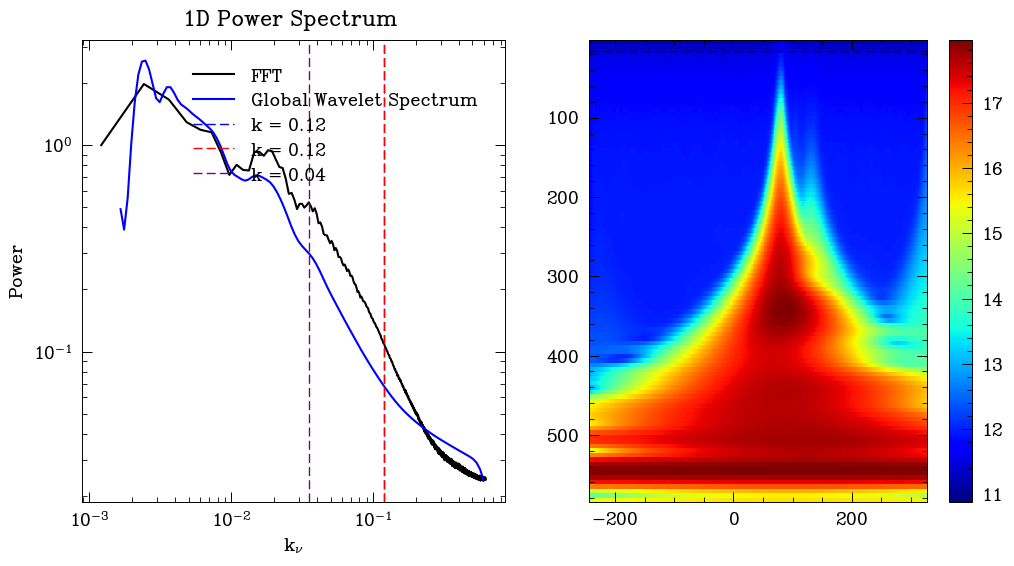

In [33]:

fig = plt.figure(figsize=(12, 6))    

plt.subplot(1, 2, 1)
plt.loglog(np.abs(fftfreqs), total_fft/total_fft[0], label='FFT', c='k')
plt.loglog(np.abs(1/period), total_global_ws/total_fft[0], label='Global Wavelet Spectrum', c='b')
plt.title(f'1D Power Spectrum ')
# add line at k = 0.12
plt.axvline(0.12, color='blue', lw=1, ls='--', label='k = 0.12')
plt.axvline(np.abs(1/period)[idx], color='red', lw=1, ls='--', label=f'k = {np.abs(1/period)[idx]:.2f}')
plt.axvline(np.abs(fftfreqs)[idx], color='purple', lw=1, ls='--', label=f'k = {np.abs(fftfreqs)[idx]:.2f}')


plt.xlabel(r'$k_\nu$')
plt.ylabel('Power')
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(np.log2(total_power), cmap='jet', origin='lower', aspect='auto', extent= [velocity_spider.min(), velocity_spider.max(), scales.min(), scales.max()])
plt.colorbar()
plt.axhline(1/(0.12 * 2*np.pi/(6 + np.sqrt(2+6**2))), color='black', lw=1, ls='--',)

plt.gca().invert_yaxis()

# plt.yscale('log', base=2)
# plt.pcolormesh(velocity, period, total_power, cmap='jet')
# plt.colorbar()
# # COI
# plt.plot(velocity, coi, )
# plt.fill_between(velocity, coi * 0 + period[-1], coi, facecolor="none", edgecolor="k", hatch='x')

#     # Scaling 
# plt.yscale('log', base=2, subs=None)
# plt.ylim([np.min(period), np.max(period)])
ax = plt.gca().yaxis
ax.set_major_formatter(ticker.ScalarFormatter())
plt.ticklabel_format(axis='y', style='plain')
plt.show()


In [34]:
N_hi_cold_cube = np.array([filtered_spider_cube[i]*column_density for i in np.arange(spider_data.shape[0])])
print('N_hi_cold_cube:', N_hi_cold_cube.shape)

f_cnm_cold_cube = np.array([filtered_spider_cube[i] for i in np.arange(spider_data.shape[0])])
f_cnm_cold_cube = filtered_spider_cube
hdu0 = fits.PrimaryHDU(N_hi_cold_cube)
hdulist = fits.HDUList([hdu0])
hdulist.writeto("N_hi_cold_cube_filtered_spider.fits", overwrite=True)

N_hi_cold_cube: (711, 172, 171)


In [80]:
fft.shape

(511,)

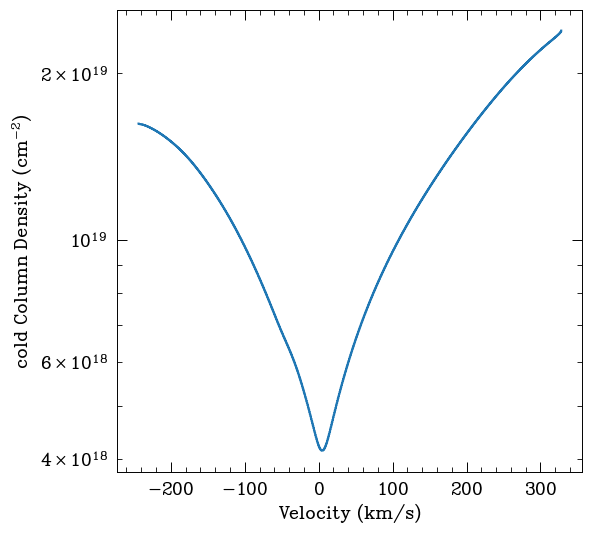

In [35]:
# sum along axis 1 and 2 N_hi_cold_cube
N_hi_cold_cube_sum = np.sum(N_hi_cold_cube, axis=(1,2))

plt.step(velocity_spider, N_hi_cold_cube_sum, label=r'$N_{HI, cold}$)')
# set y scale log
plt.yscale('log')
plt.xlabel('Velocity (km/s)')
plt.ylabel('cold Column Density (cm$^{-2}$)')
plt.show()

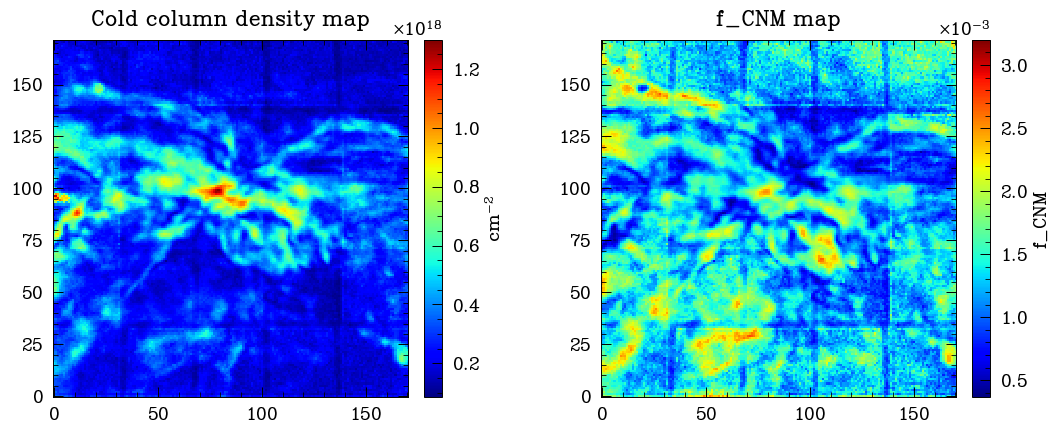

In [37]:
# 1 by2 figure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# add padding to the subplots
plt.tight_layout(pad=5)
# plot the first moment map
im1 = axs[0].imshow(np.sum(N_hi_cold_cube, axis = 0), cmap='jet', origin='lower')
axs[0].set_title('Cold column density map')
fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04, label='cm$^{-2}$')

# plot the second moment map
avg_fcnm = np.sum(f_cnm_cold_cube, axis = 0) / f_cnm_cold_cube.shape[0]
im2 = axs[1].imshow(avg_fcnm, cmap='jet', origin='lower')
axs[1].set_title('f_CNM map')
fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04, label='f_CNM')

plt.show()



In [493]:

DS9_b = ['#000000', '#0000FF', '#8B00FF', '#FF0000', '#FFA500', '#FFFF00', '#FFFFFF']
camps_DS9 = LinearSegmentedColormap.from_list('1', DS9_b)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs_spider.celestial)

N_hi_cold_cube = fits.getdata('N_hi_cold_cube_filtered_spider.fits')

plt.gca().coords[1].set_ticks(spacing=1 * u.deg)
plt.gca().coords[1].set_major_formatter('dd')
plt.gca().coords[0].set_major_formatter('hh:mm:ss')
plt.gca().coords[0].set_ticks(spacing=5.0 * u.deg)
plt.gca().grid(color='grey', ls='solid', alpha=0.4)

im = ax.imshow(N_hi_cold_cube[0], cmap=camps_DS9, origin='lower')
velocity_spider = spider_moments.spectral_axis.to(u.km / u.s)

pbar = tqdm(total=N_hi_cold_cube.shape[0])


def animate(i):
    im.set_array(N_hi_cold_cube[i])
    ax.set_title('Velocity = {:.2f}'.format(velocity_spider[i]))
    pbar.update(1)
    return im,

ani = animation.FuncAnimation(fig, animate, frames=N_hi_cold_cube.shape[0], blit=True)
ani.save('HI_spdier.gif', writer='imagemagick', fps=20)
#ani.save('/Volumes/PortableSSD/temp/HI_askap_parkes_inferno.gif', writer='imagemagick', fps=10)


  0%|          | 1/711 [00:00<01:51,  6.39it/s]MovieWriter imagemagick unavailable; using Pillow instead.
714it [05:18,  2.03it/s]                         

KeyboardInterrupt: 

In [ ]:
# 
# with fits.open('RSAA_SP/Data/GHIGLS_SPIDER_Tb.fits', mode='update') as hdul:
#     if hdul[0].header['CUNIT3'] == 'M/S':
#         hdul[0].header['CUNIT3'] = 'm/s'  # Correct the unit
#     hdul.flush()  # Write changes to the file




# Case Study 5: The LMC

In [46]:
lmc_path = 'RSAA_SP/Data/lmc.hi.K.LSR.fits'
lmc_data = fits.getdata(lmc_path)
lmc_moments = SpectralCube.read(fits.open(lmc_path))
velocity_lmc = lmc_moments.spectral_axis.to(u.km/u.s).value

print('lmc_data shape:', lmc_data.shape)



lmc_data shape: (122, 1350, 1350)


In [48]:
column_density_lmc = np.nansum(lmc_data*1.823*10**18 , axis=0) 
column_density_lmc

array([[ 1.72619117e+19,  1.05040070e+20,  1.95008893e+20, ...,
         1.03088024e+20,  3.80677509e+19, -2.74773396e+19],
       [ 1.13254879e+20,  2.15535425e+20,  2.27765311e+20, ...,
         5.83126526e+19,  2.54295530e+19,  5.83627275e+18],
       [ 2.34471276e+20,  2.84586041e+20,  2.18955435e+20, ...,
         3.47258701e+19,  3.54111143e+19,  3.53121733e+19],
       ...,
       [-1.24176498e+20, -3.57104794e+19,  4.62627833e+19, ...,
         8.43840287e+19,  1.57027867e+20,  1.68011580e+20],
       [-7.56213600e+19, -1.97166186e+19,  1.63660638e+18, ...,
         8.89231320e+19,  1.38856703e+20,  1.45940830e+20],
       [-1.02627768e+19,  3.86302319e+19,  2.12949000e+19, ...,
         1.03148149e+20,  1.32436084e+20,  1.32382829e+20]])

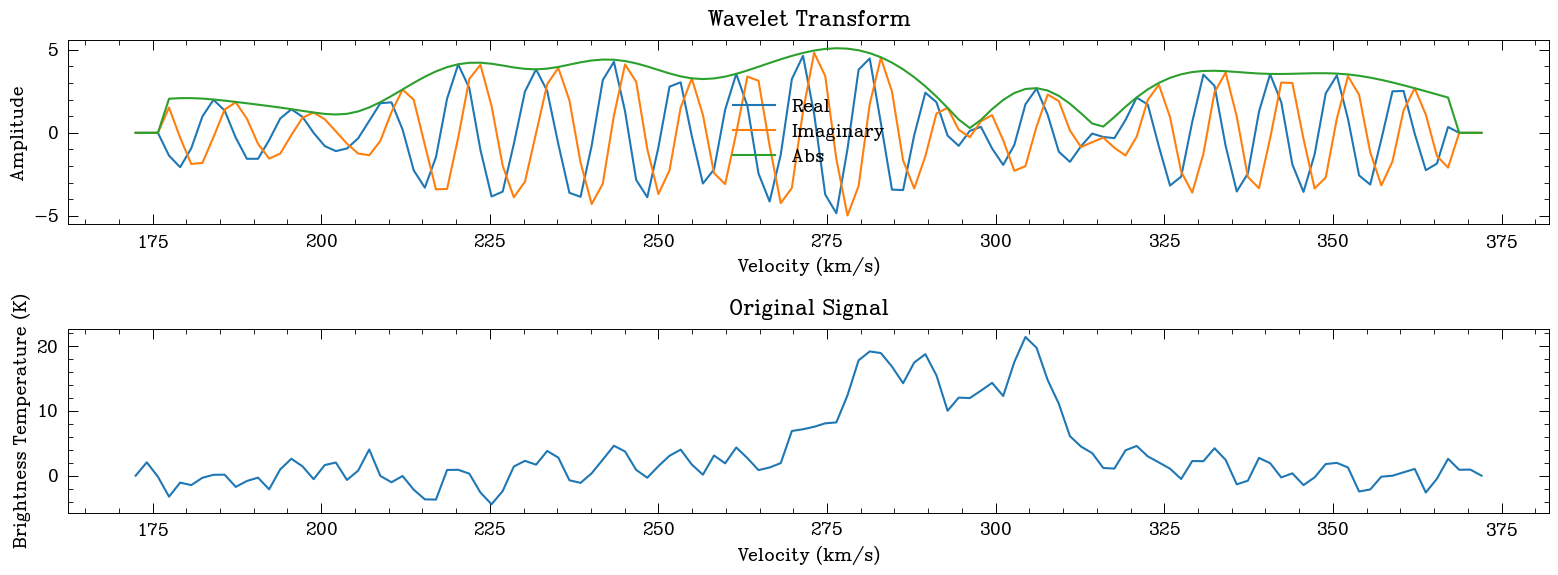

100%|██████████| 1350/1350 [06:09<00:00,  3.66it/s]


In [62]:
filtered_lmc_cube = np.zeros(lmc_data.shape)

total_power_lmc = np.zeros((73, len(velocity_lmc))) # Power at every scale along the velocity axis
total_global_ws_lmc = np.zeros(73) # Global wavelet spectrum
total_fft_lmc = np.zeros(63) # Fourier power spectrum

lmc_data[lmc_data != lmc_data] = 0  # Set the NaN values to zero

for i in tqdm(np.arange(lmc_data.shape[1])):
    for j in np.arange(lmc_data.shape[2]):
        x = lmc_data[:, i, j]
        dv = np.diff(velocity_lmc)[0]
        # wave, scales, freqs, power, global_ws, fft_power, fft_power_norm, fftfreqs, period, coi = generate_wavelet_transform(x, velocity_lmc)
        # total_power_lmc += power 
        # total_global_ws_lmc += global_ws
        # total_fft_lmc += fft_power
        # idx = np.argmin(np.abs(np.abs(1/period) - 0.12)) 
        # cold_gas = power[idx]  / wave.shape[1]  # Normalized power
        # filtered_lmc_cube[:, i, j] = cold_gas


        wave, period, scale, coi, fft_signal, fft_freqs = wavelet(x, dv, mother='MORLET', k_v=0.12)
     

        # fft_poer = np.abs(fft_signal)
        power = np.abs(wave) #/ fft_power[0] #/ wave.shape[1]
        #global_ws = np.sum(power, axis=1) # / fft_power[0]/ wave.shape[1]
     


        #total_power_lmc += power # Power at every scale along the velocity axis (2D power spectrum at each pixel) 
        # total_global_ws_lmc += global_ws # Global (1D) wavelet spectrum at each pixel
        # total_fft_lmc += fft_power # Fourier power spectrum at each pixel  

        # plot spectrum and wavelet power spectrum  

        if i == 400 and j == 200:
            plt.figure(figsize=(16, 6) )

            plt.subplot(2, 1, 1) # Change to 2 rows, 1 column, first plot
            plt.plot(velocity_lmc, np.real(wave[0]), label='Real') # Real part of the wave
            plt.plot(velocity_lmc, np.imag(wave[0]), label='Imaginary') # Imaginary part of the wave
            plt.plot(velocity_lmc, np.abs(wave[0]), label='Abs') # Absolute value of the wave
            plt.title('Wavelet Transform')
            plt.xlabel('Velocity (km/s)')
            plt.ylabel('Amplitude')
            plt.legend()

            plt.subplot(2, 1, 2) # Second plot in the 2 rows, 1 column grid
            plt.plot(velocity_lmc, x) # Original signal
            plt.title('Original Signal')
            plt.xlabel('Velocity (km/s)')
            plt.ylabel('Brightness Temperature (K)')

            plt.tight_layout() # This makes sure that the plots do not overlap
            plt.show()



    

        # f_cnm = power 
        filtered_lmc_cube[:, i, j] = power/np.max(power)




In [ ]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

# Assuming generate_wavelet_transform is defined elsewhere and is thread-safe

def process_column(i, lmc_data, velocity_lmc):

    total_power_lmc_col = np.zeros((73, len(velocity_lmc))) # 2D wavelet power spectrum 
    total_global_ws_lmc_col = np.zeros(73) # Global (1D) wavelet spectrum
    total_fft_lmc_col = np.zeros(63) # 1D Fourier power spectrum
    filtered_lmc_cube_col = np.zeros((lmc_data.shape[0], lmc_data.shape[2])) # Filtered cube

    for j in range(lmc_data.shape[2]):
        x = lmc_data[:, i, j]
        wave, scales, freqs, power, global_ws, fft_power, fft_power_norm, fftfreqs, period, coi = generate_wavelet_transform(x, velocity_lmc)

        total_power_lmc_col += power
        total_global_ws_lmc_col += global_ws
        total_fft_lmc_col += fft_power

        idx = np.argmin(np.abs(np.abs(1/period) - 0.12))
        cold_gas = power[idx] / wave.shape[1]

        filtered_lmc_cube_col[:, j] = cold_gas

    return total_power_lmc_col, total_global_ws_lmc_col, total_fft_lmc_col, filtered_lmc_cube_col

def main(lmc_data, velocity_lmc):
    lmc_data[lmc_data != lmc_data] = 0  # Set NaN values to zero

    with ProcessPoolExecutor(max_workers=12) as executor:
        results = list(tqdm(executor.map(process_column, range(lmc_data.shape[1]), [lmc_data]*lmc_data.shape[1], [velocity_lmc]*lmc_data.shape[1]), total=lmc_data.shape[1]))

    # Initialize the arrays to accumulate the results
    filtered_lmc_cube = np.zeros(lmc_data.shape)
    total_power_lmc = np.zeros((73, len(velocity_lmc)))
    total_global_ws_lmc = np.zeros(73)
    total_fft_lmc = np.zeros(63)

    for result in results:
        total_power_lmc += result[0]
        total_global_ws_lmc += result[1]
        total_fft_lmc += result[2]
        filtered_lmc_cube[:, :, range(lmc_data.shape[2])] += result[3]

    return filtered_lmc_cube, total_power_lmc, total_global_ws_lmc, total_fft_lmc

# Use the main function with your data
filtered_lmc_cube, total_power_lmc, total_global_ws_lmc, total_fft_lmc = main(lmc_data, velocity_lmc)


In [63]:

N_hi_cold_cube_lmc = np.array([filtered_lmc_cube[i]*column_density_lmc for i in np.arange(lmc_data.shape[0])])
print('N_hi_cold_cube_lmc:', N_hi_cold_cube_lmc.shape)

f_cnm_cold_cube_lmc = np.array([filtered_lmc_cube[i] for i in np.arange(lmc_data.shape[0])])

hdu0 = fits.PrimaryHDU(N_hi_cold_cube_lmc)
hdulist = fits.HDUList([hdu0])
hdulist.writeto("N_hi_cold_cube_filtered_lmc.fits", overwrite=True)



# fig = plt.figure(figsize=(12, 6))    
# plt.subplot(1, 2, 1)
# plt.loglog(np.abs(fftfreqs), total_fft, label='FFT', c='k')
# plt.loglog(np.abs(1/period), total_global_ws, label='Global Wavelet Spectrum', c='b')
# plt.title(f'1D Power Spectrum ')
# plt.axvline(0.12, color='blue', lw=1, ls='--', label='k = 0.12')
# plt.xlabel(r'$k_\nu$')
# plt.ylabel('Power')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.imshow(np.log2(total_power), cmap='jet', origin='lower', aspect='auto')
# plt.colorbar()
# plt.gca().invert_yaxis()
# ax = plt.gca().yaxis
# ax.set_major_formatter(ticker.ScalarFormatter())
# plt.ticklabel_format(axis='y', style='plain')
# plt.show()


N_hi_cold_cube_lmc: (122, 1350, 1350)


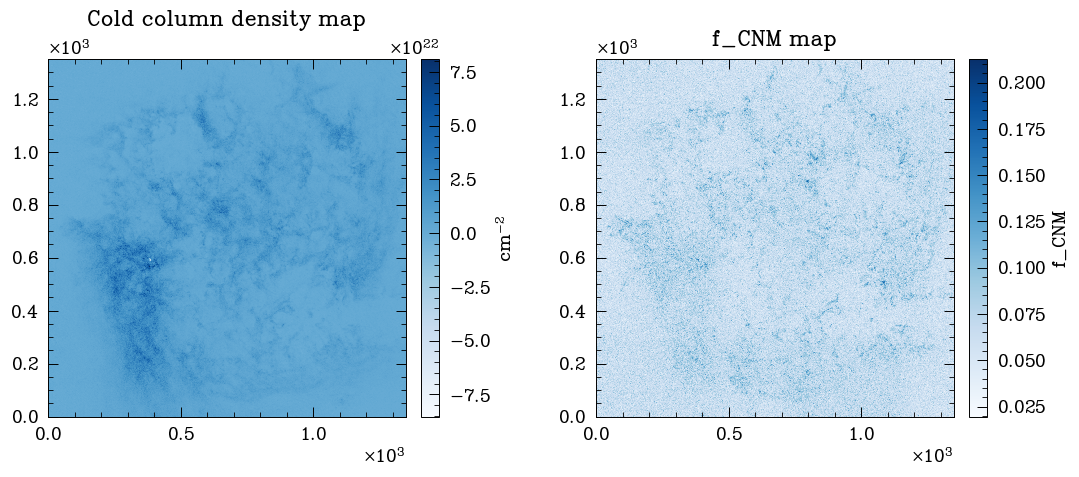

In [64]:
# 1 by2 figure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.tight_layout(pad=5)

im1 = axs[0].imshow(np.sum(N_hi_cold_cube_lmc, axis = 0), cmap='Blues', origin='lower')
axs[0].set_title('Cold column density map')
fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04, label='cm$^{-2}$')

# This is the mean of the f_cnm map NOT the moment 0 map. Moment 0 gives values > 1 because sum 
avg_fcnm = np.sum(f_cnm_cold_cube_lmc, axis=0)/f_cnm_cold_cube_lmc.shape[0]
# avg_fcnm = np.average(f_cnm_cold_cube, axis=0)
im2 = axs[1].imshow(avg_fcnm, cmap='Blues', origin='lower')
axs[1].set_title('f_CNM map')
fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04, label='f_CNM')

plt.show()


# Case Study 6: The SMC

gass_data shape: (195, 125, 125)
Velocity shape: (195,)
WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---CAR'  'DEC--CAR'  'VOPT'  
CRVAL : 13.18666666667  0.0  79976.50146484  
CRPIX : 63.0  973.3576388889  1.0  
NAXIS : 125  125  195


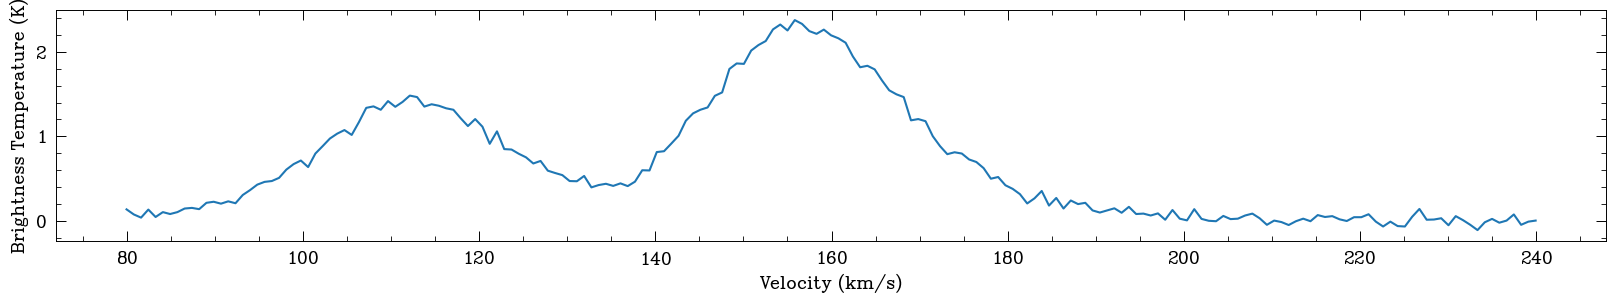

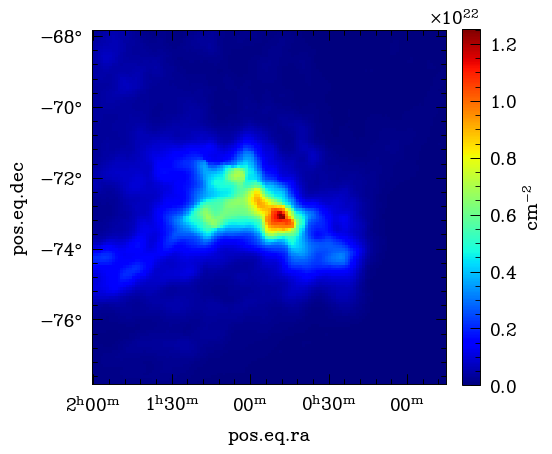

In [7]:
path = '/Users/jasonprice/Desktop/SMC_data/HI/Galatic All Sky Survey/fits_gass_13_-73_1677113825.fits'
gass_data = fits.getdata(path)
SMC_GASS_2 = fits.open(path) 
SMC_GASS_2[0].header['CUNIT3'] = 'm/s'
gass_moments = SpectralCube.read(SMC_GASS_2)
velocity_gass = gass_moments.spectral_axis.to(u.km/u.s).value
wcs_gass_smc = gass_moments.wcs

column_density_smc = np.sum(gass_data*1.823*10**18, axis=0)   # m/s to km/s

### read in ASKAP data as 


print('gass_data shape:', gass_data.shape)
print('Velocity shape:', velocity_gass.shape)
print(wcs_gass_smc)

# plot a spectum from the middle of the data
plt.figure(figsize=(20, 3))
plt.plot(velocity_gass, gass_data[:,30, 80])
plt.xlabel('Velocity (km/s)')
plt.ylabel('Brightness Temperature (K)')


# plot the HI column density image by summing along the velocity axis
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection = wcs_gass_smc.celestial)
im = ax.imshow(column_density_smc, cmap='jet', origin='lower', )
plt.colorbar(im, fraction=0.046, pad=0.04, label='cm$^{-2}$')
plt.show()


 63%|██████▎   | 79/125 [00:05<00:01, 27.39it/s]

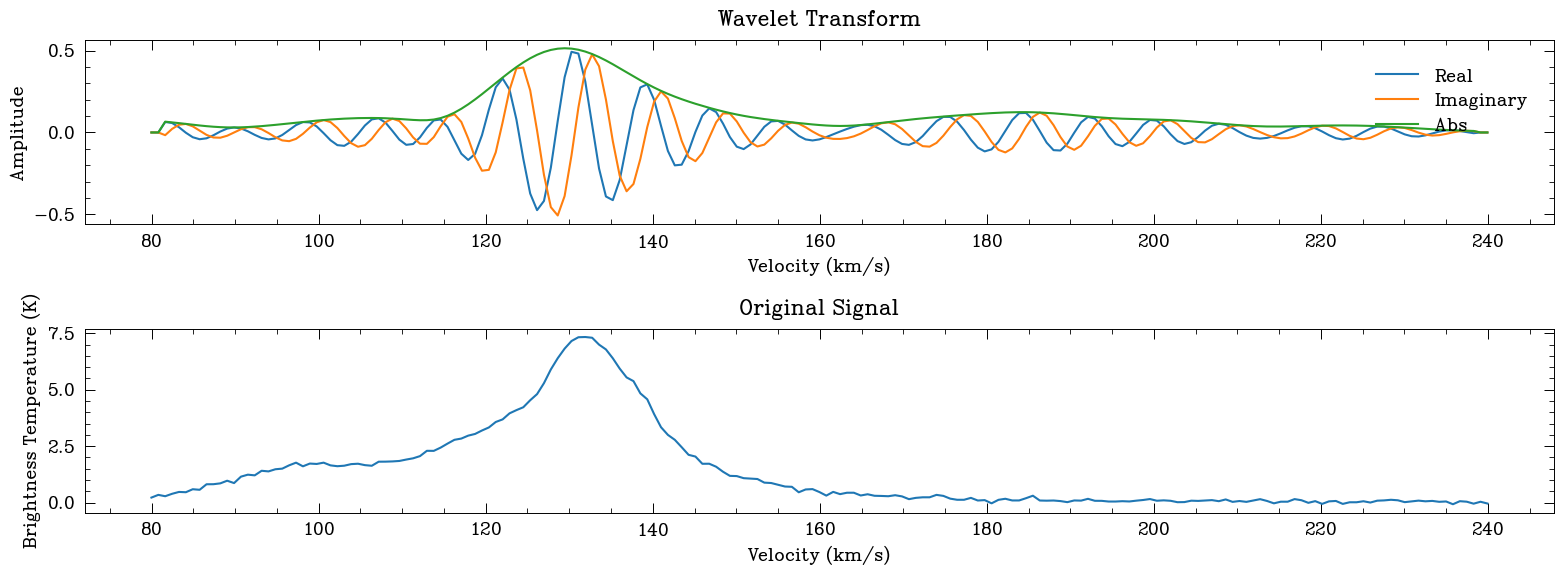

100%|██████████| 125/125 [00:08<00:00, 15.13it/s]


N_hi_cold_cube: (195, 125, 125)
f_cnm_cold_cube: (195, 125, 125)
Filtered cube shape: (195, 125, 125)
Wave shape: (1, 195)
Power shape: (1, 195)
global_ws shape: (1,)


In [9]:
# Apply wavelet transform to the spider data

filtered_smc_cube = np.zeros(gass_data.shape)

total_power = [0] 
total_global_ws = [0] 
total_fft = np.zeros(195) # Fourier power spectrum


gass_data[gass_data != gass_data] = 0  # Set the NaN values to zero

for i in tqdm(np.arange(gass_data.shape[1])):
    for j in np.arange(gass_data.shape[2]):

        x = gass_data[:, i, j] # spectrum at each pixel
        dv = np.diff(velocity_gass)[0]


        # wave, scales, freqs, power, global_ws, fft_power, fft_power_norm, fftfreqs, period, coi, fft = generate_wavelet_transform(x, velocity_gass)
        wave, period, scale, coi, fft_signal, fft_freqs = wavelet(x, dv, mother='MORLET')
     


        fft_power = np.abs(fft_signal)
        power = np.abs(wave) #/ fft_power[0] #/ wave.shape[1]
        global_ws = np.sum(power, axis=1) # / fft_power[0]/ wave.shape[1]
     


        total_power += power # Power at every scale along the velocity axis (2D power spectrum at each pixel) 
        total_global_ws += global_ws # Global (1D) wavelet spectrum at each pixel
        total_fft += fft_power # Fourier power spectrum at each pixel  

        # plot spectrum and wavelet power spectrum  

        if i == 80 and j == 80:
            plt.figure(figsize=(16, 6) )

            plt.subplot(2, 1, 1) # Change to 2 rows, 1 column, first plot
            plt.plot(velocity_gass, np.real(wave[0]), label='Real') # Real part of the wave
            plt.plot(velocity_gass, np.imag(wave[0]), label='Imaginary') # Imaginary part of the wave
            plt.plot(velocity_gass, np.abs(wave[0]), label='Abs') # Absolute value of the wave
            plt.title('Wavelet Transform')
            plt.xlabel('Velocity (km/s)')
            plt.ylabel('Amplitude')
            plt.legend()

            plt.subplot(2, 1, 2) # Second plot in the 2 rows, 1 column grid
            plt.plot(velocity_gass, x) # Original signal
            plt.title('Original Signal')
            plt.xlabel('Velocity (km/s)')
            plt.ylabel('Brightness Temperature (K)')

            plt.tight_layout() # This makes sure that the plots do not overlap
            plt.show()



    

        # f_cnm = power 
        filtered_smc_cube[:, i, j] = power/np.max(power)


        # identify the cold gas component
        # target_x = 0.12
        # idx = np.argmin(np.abs(np.abs(1/period) - target_x))
 
    
        # Clip power spectrum baed on the COI - TODO!!
        # clip the power spectrum based on the COI


        # fft_tb_power = (np.abs(fft))
        # cold_gas = ((((np.abs(wave))[idx])/fft_tb_power[0]/wave.shape[1])) #*T_b

        # f_cnm = np.sum(power[idx]) / np.sum(power, axis=0) / power.shape[1] # fraction of the power in the cold gas component
        # Fcnm should be an array with length velcoity range, replace the value at every pixel with the value at the index of the target_x

 
        


N_hi_cold_cube = np.array([filtered_smc_cube[i]*column_density_smc for i in np.arange(gass_data.shape[0])])
print('N_hi_cold_cube:', N_hi_cold_cube.shape)

f_cnm_cold_cube = np.array([filtered_smc_cube[i] for i in np.arange(gass_data.shape[0])]) 
print('f_cnm_cold_cube:', f_cnm_cold_cube.shape)

hdu0 = fits.PrimaryHDU(data = N_hi_cold_cube, header=SMC_GASS_2[0].header)
hdulist = fits.HDUList([hdu0])
hdulist.writeto("N_hi_cold_cube_filtered_smc.fits", overwrite=True)


print('Filtered cube shape:', filtered_smc_cube.shape)
print('Wave shape:', wave.shape)
print('Power shape:', power.shape)
print('global_ws shape:', global_ws.shape)
# print('period shape:', period.shape)
# print('idx:', idx)

In [ ]:
fig = plt.figure(figsize=(12, 6))    

plt.subplot(1, 2, 1)
plt.loglog(np.abs(fft_freqs), total_fft/total_fft[0], label='FFT', c='k')
plt.scatter(np.abs(1/period), total_global_ws/195, label='Global Wavelet Spectrum', c='b', lw=14)

plt.axvline(0.12, color='blue', lw=1, ls='--', label='k = 0.12')
plt.title(f'1D Power Spectrum ')
plt.xlabel(r'$k_\nu$')
plt.ylabel('Power')
# plt.legend()


plt.show()




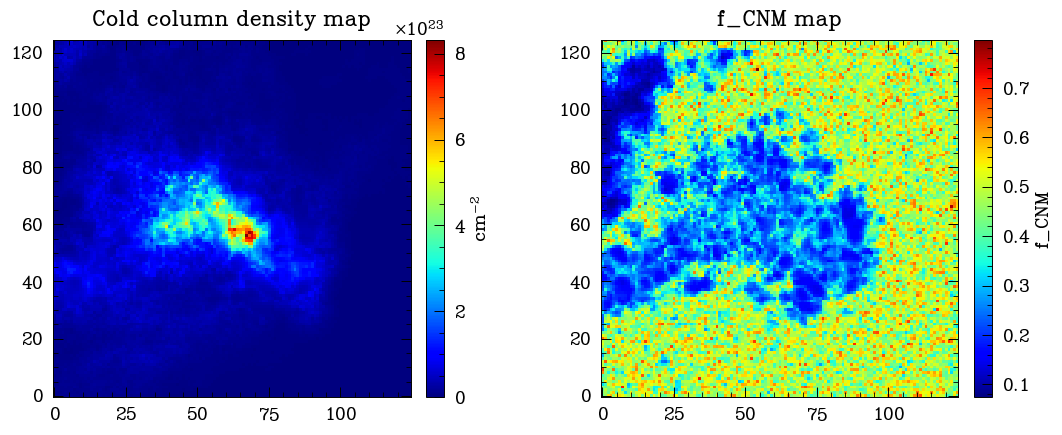

In [24]:

# 1 by2 figure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.tight_layout(pad=5)

im1 = axs[0].imshow(np.sum(N_hi_cold_cube, axis = 0), cmap='jet', origin='lower')
axs[0].set_title('Cold column density map')
fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04, label='cm$^{-2}$')

# This is the mean of the f_cnm map NOT the moment 0 map. Moment 0 gives values > 1 because sum 
avg_fcnm = np.sum(f_cnm_cold_cube, axis=0)/f_cnm_cold_cube.shape[0]
# avg_fcnm = np.average(f_cnm_cold_cube, axis=0)
im2 = axs[1].imshow(avg_fcnm, cmap='jet', origin='lower',)
axs[1].set_title('f_CNM map')
fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04, label='f_CNM')

plt.show()


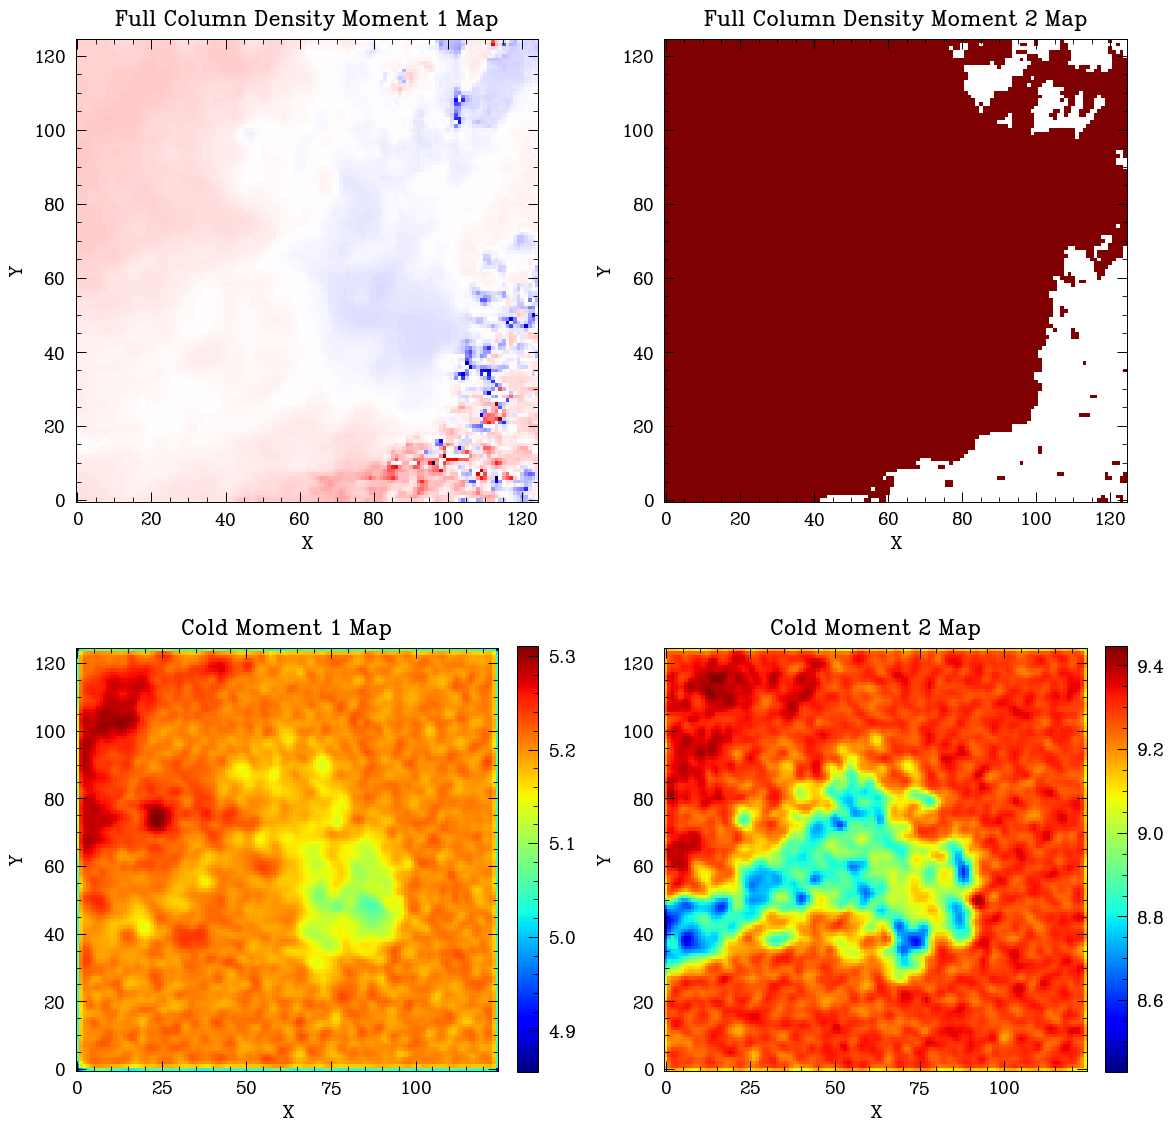

In [11]:
from astropy.convolution import Gaussian2DKernel
from spectral_cube import SpectralCube
from astropy.convolution import Gaussian2DKernel, convolve
from spectral_cube import SpectralCube
# moment 1 map of the cold which direction is the cold gas moving in

# moment maps from fit file as spectral cube
f_cnm_cold_cube_smc = SpectralCube.read('N_hi_cold_cube_filtered_smc.fits')
mom1_fcnm = gass_moments.moment(order=1)
mom2_fcnm = gass_moments.moment(order=2)



# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot the full column density moment maps in the top row
axs[0, 0].imshow(np.log10(mom1_fcnm.value), cmap='seismic', origin='lower',)
axs[0, 0].set_title('Full Column Density Moment 1 Map')
axs[0, 0].set_xlabel('X')
axs[0, 0].set_ylabel('Y')

axs[0, 1].imshow(np.log10(mom2_fcnm.value), cmap='jet', origin='lower', vmin=0, vmax=1)
axs[0, 1].set_title('Full Column Density Moment 2 Map')
axs[0, 1].set_xlabel('X')
axs[0, 1].set_ylabel('Y')

# Plot the cold moment maps in the bottom row

# Smooth the moment maps with a Gaussian kernel to reduce noise
mom1_coldN_hi = f_cnm_cold_cube_smc.moment(order=1).value
mom2_coldN_hi = f_cnm_cold_cube_smc.moment(order=2).value

# smooth the moment maps with a Gaussian kernel to reduce noise
kernel = Gaussian2DKernel(x_stddev=1)
mom1_coldN_hi = convolve(mom1_coldN_hi, kernel)
mom2_coldN_hi = convolve(mom2_coldN_hi, kernel)

mom1_coldN_hi = np.log10(mom1_coldN_hi)
mom2_coldN_hi = np.log10(mom2_coldN_hi)


im1 = axs[1, 0].imshow(mom1_coldN_hi, cmap='jet', origin='lower')
axs[1, 0].set_title('Cold Moment 1 Map')
axs[1, 0].set_xlabel('X')
axs[1, 0].set_ylabel('Y')
# Create colorbar for the first subplot
plt.colorbar(im1, ax=axs[1, 0], fraction=0.046, pad=0.04)

im2 = axs[1, 1].imshow(mom2_coldN_hi, cmap='jet', origin='lower')
axs[1, 1].set_title('Cold Moment 2 Map')
axs[1, 1].set_xlabel('X')
axs[1, 1].set_ylabel('Y')
# Create colorbar for the second subplot
plt.colorbar(im2, ax=axs[1, 1], fraction=0.046, pad=0.04)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
# GIF of the HI column density map

DS9_b = ['#000000', '#0000FF', '#8B00FF', '#FF0000', '#FFA500', '#FFFF00', '#FFFFFF']
camps_DS9 = LinearSegmentedColormap.from_list('1', DS9_b)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=wcs_gass_smc.celestial)

N_hi_cold_cube = fits.getdata('N_hi_cold_cube_filtered_smc.fits')

plt.gca().coords[1].set_ticks(spacing=1 * u.deg)
plt.gca().coords[1].set_major_formatter('dd')
plt.gca().coords[0].set_major_formatter('hh:mm:ss')
plt.gca().coords[0].set_ticks(spacing=5.0 * u.deg)
plt.gca().grid(color='grey', ls='solid', alpha=0.4)

im = ax.imshow(N_hi_cold_cube[0], cmap='seismic', origin='lower')

pbar = tqdm(total=N_hi_cold_cube.shape[0])


def animate(i):
    im.set_array(N_hi_cold_cube[i])
    ax.set_title('Velocity = {:.2f}'.format(velocity_gass[i]))
    pbar.update(1)
    return im,

ani = animation.FuncAnimation(fig, animate, frames=N_hi_cold_cube.shape[0], blit=True)
ani.save('HI_smc_cwt_cold.gif', writer='imagemagick', fps=20)
#ani.save('/Volumes/PortableSSD/temp/HI_askap_parkes_inferno.gif', writer='imagemagick', fps=10)


  1%|          | 1/195 [00:00<00:32,  5.97it/s]MovieWriter imagemagick unavailable; using Pillow instead.
198it [01:31,  2.34it/s]                         

In [ ]:
# mask all values below 10^20 in N_hi_cold_cube
N_hi_cold_cube[N_hi_cold_cube < 10**18] = np.nan



plt.imshow(np.sum(N_hi_cold_cube, axis = 0), cmap='jet', origin='lower')
plt.colorbar()
plt.show()

In [241]:
import webbrowser
import plotly.graph_objects as go
import os


# Create the x, y, and z coordinates for the 3D plot N_hi_cold_cube with, th index of [1] and [2] are the x and y coordinates and index [0] is the z coordinate and the value held at each index is the value of the pixel at that coordinate
x, y = np.meshgrid(np.arange(N_hi_cold_cube.shape[2]), np.arange(N_hi_cold_cube.shape[1]))

# Create the 3D plot
fig = go.Figure(data=[go.Surface(z=N_hi_cold_cube[0], x=x, y=y, colorscale='tempo', showscale=True)])

fig.update_layout(title='Cold HI Column Density Map', autosize=False, width=800, height=800, margin=dict(l=65, r=50, b=65, t=90))
fig.update_scenes(aspectmode='manual', aspectratio=dict(x=1, y=1, z=0.5))

#  add a color bar
fig.update_layout(coloraxis_showscale=True)


fig.write_html("my_plot.html")

# Open the file in the default browser

file_path = 'my_plot.html'
absolute_path = os.path.abspath(file_path)

# Open the HTML file in the default web browser
webbrowser.open('file://' + absolute_path, new=2)

True

In [235]:
velocity_gass

array([ 79.97650146,  80.80100149,  81.62550151,  82.45000154,
        83.27450156,  84.09900159,  84.92350161,  85.74800164,
        86.57250166,  87.39700168,  88.22150171,  89.04600173,
        89.87050176,  90.69500178,  91.51950181,  92.34400183,
        93.16850185,  93.99300188,  94.8175019 ,  95.64200193,
        96.46650195,  97.29100198,  98.115502  ,  98.94000202,
        99.76450205, 100.58900207, 101.4135021 , 102.23800212,
       103.06250215, 103.88700217, 104.71150219, 105.53600222,
       106.36050224, 107.18500227, 108.00950229, 108.83400232,
       109.65850234, 110.48300236, 111.30750239, 112.13200241,
       112.95650244, 113.78100246, 114.60550249, 115.43000251,
       116.25450253, 117.07900256, 117.90350258, 118.72800261,
       119.55250263, 120.37700266, 121.20150268, 122.02600271,
       122.85050273, 123.67500275, 124.49950278, 125.3240028 ,
       126.14850283, 126.97300285, 127.79750288, 128.6220029 ,
       129.44650292, 130.27100295, 131.09550297, 131.92

In [ ]:
# inner product of the fft wavlet and signla at one scale, accross b


# AM code

In [1]:
import numpy as np
import plotly.graph_objects as go
import os
import webbrowser
import tqdm
import matplotlib.pyplot as plt
from astropy.io import fits

path = '/Users/jasonprice/SMC_askap_parkes_PBC_K_100_arcs_wave_0.12.fits'

data = fits.getdata(path)

data[:, :int(data.shape[1]*0.1), :] = np.nan
data[:, -int(data.shape[1]*0.1):, :] = np.nan
data[:, :, :int(data.shape[2]*0.1)] = np.nan
data[:, :, -int(data.shape[2]*0.1):] = np.nan


In [11]:



# Parameters (set according to your data)
vmin = 2
vmax = 12
chunk_size = 10  # Number of z-slices to process at a time

# Initialize the figure
fig = go.Figure()

# Process the data in chunks
for z_start in tqdm.tqdm(range(0, data.shape[0], chunk_size)):
    z_end = min(z_start + chunk_size, data.shape[0])
    chunk_data = data[z_start:z_end]

    # Flatten the chunk for x, y, z coordinates
    x, y = np.meshgrid(np.arange(chunk_data.shape[2]), np.arange(chunk_data.shape[1]))
    z = np.arange(z_start, z_end)[:, None, None]

    # Repeat x, y for each slice and flatten
    x_flat = np.tile(x, (z_end - z_start, 1, 1)).flatten()
    y_flat = np.tile(y, (z_end - z_start, 1, 1)).flatten()
    z_flat = np.repeat(z, x.shape[0] * x.shape[1]).flatten()

    # Flatten the data chunk and clip the values
    values_flat = chunk_data.flatten()
    clipped_values = np.clip(values_flat, vmin, vmax)

    # Normalize the values
    norm_values = (clipped_values - vmin) / (vmax - vmin)

    # Add the chunk data to the figure
    fig.add_trace(go.Scatter3d(x=x_flat, y=y_flat, z=z_flat, mode='markers', 
                               marker=dict(size=2, color=norm_values, colorscale='Viridis', opacity=0.8)))

# Update the layout once, after all chunks have been processed
fig.update_layout(title='3D Data Visualization', autosize=False, width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.update_scenes(aspectmode='cube')

# Save the plot as an HTML file and open it
fig.write_html("my_chunked_plot.html")
webbrowser.open('file://' + os.path.abspath("my_chunked_plot.html"), new=2)



  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [01:01<00:00,  2.81s/it]


In [2]:


# Create a volume trace
trace = go.Volume(
    x=np.arange(data.shape[1]),
    y=np.arange(data.shape[2]),
    z=np.arange(data.shape[0]),
    value=data.transpose(2, 1, 0),
    isomin=np.nanmin(data),
    isomax=np.nanmax(data),
    opacity=0.1,
    surface_count=20,
    caps=dict(x_show=False, y_show=False, z_show=False)
)

# Create a figure and add the volume trace
fig = go.Figure(data=trace)

# Update the layout
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    margin=dict(l=0, r=0, b=0, t=0)
)

# Write the figure to an HTML file and open it in a web browser
fig.write_html('plot.html', auto_open=True)

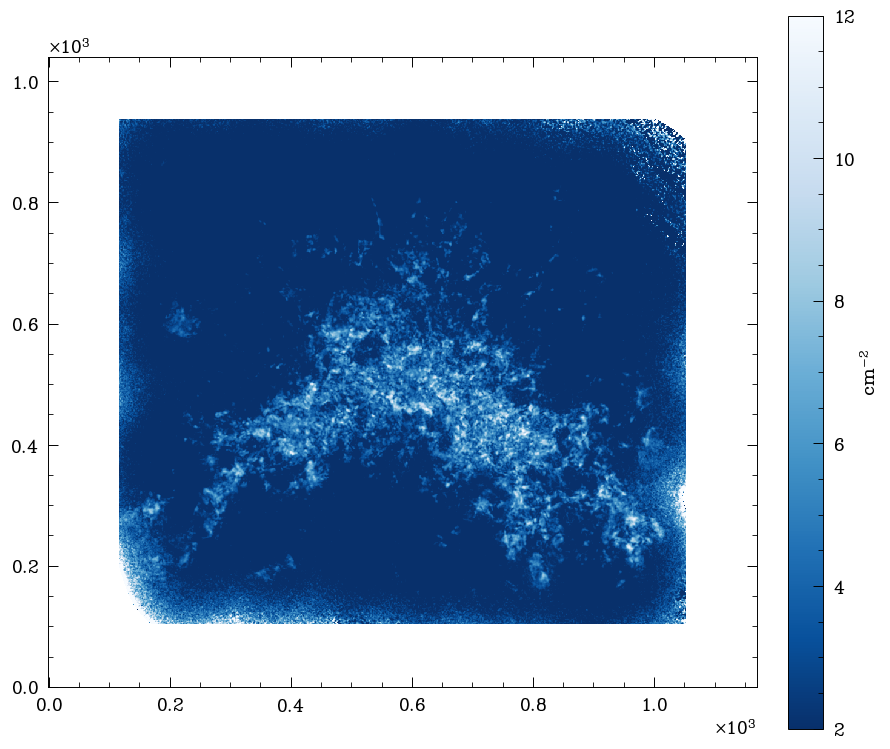

In [10]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(np.sum(data, axis =0), cmap='Blues_r', origin='lower', vmin=2, vmax=12)
plt.colorbar( pad=0.04, fraction=0.046, label='cm$^{-2}$')
plt.show()
